# Interview Assignment - Blindspot Solutions
### Author: Adam Novotny

This Jupyter Notebook is concerned with **Anomaly detection** in **CSIC 2010** dataset and was created for interview assignment for Blindspot Solutions. 
The assignment consists of parsing and analyzing dataset; consequently of training and evaluating classifiers. The best performing classifier is then chosen.

## Initialization

In [1]:
import sys
import os
pwd = %pwd
sys.path.append(os.path.join(pwd, os.path.join('src')))
sys.path.append(os.path.join(pwd, os.path.join('data')))

%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import cross_val_score

## Parsing

Based on documentation, the dataset contains 36,000 normal requests and more than 25,000 anomalous requests.

In [4]:
from fun_aux import parse_file #parse_file 
txt_norm_train = 'data\\normalTrafficTraining.txt'
txt_norm_test = 'data\\normalTrafficTest.txt'
txt_anom = 'data\\anomalousTrafficTest.txt'

data_norm_train = parse_file(txt_norm_train)
data_norm_test = parse_file(txt_norm_test)
data_anom = parse_file(txt_anom)

#adding Target: 0 for "normal", 1 for "anomalous"
data_norm_train['Target'] = 0 #normal
data_norm_test['Target'] = 0 #normal
data_anom['Target'] = 1 #anomalous

data = pd.concat([data_norm_train, data_norm_test, data_anom], ignore_index=True) #concatenate into one dataframe

In [5]:
print('Shape of normal training data: ', data_norm_train.shape)
print('Shape of normal test data: ', data_norm_test.shape)
print('Shape of anomalous test data: ', data_anom.shape)

Shape of normal training data:  (36000, 17)
Shape of normal test data:  (36000, 17)
Shape of anomalous test data:  (25065, 17)


## Dataset analysis

Let's visualize first $5$ rows of DataFrame:

In [6]:
data.head(5)

,Method,URL,Protocol,UserAgent,Pragma,CacheControl,Accept,AcceptEncoding,AcceptCharset,AcceptLanguage,Host,Cookie,Connection,ContentType,ContentLength,Payload,Target
0,GET,http://localhost:8080/tienda1/index.jsp,HTTP/1.1,Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...,no-cache,no-cache,"text/xml,application/xml,application/xhtml+xml...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,localhost:8080,JSESSIONID=1F767F17239C9B670A39E9B10C3825F4,close,,0,,0
1,GET,http://localhost:8080/tienda1/publico/anadir.j...,HTTP/1.1,Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...,no-cache,no-cache,"text/xml,application/xml,application/xhtml+xml...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,localhost:8080,JSESSIONID=81761ACA043B0E6014CA42A4BCD06AB5,close,,0,,0
2,POST,http://localhost:8080/tienda1/publico/anadir.jsp,HTTP/1.1,Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...,no-cache,no-cache,"text/xml,application/xml,application/xhtml+xml...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,localhost:8080,JSESSIONID=933185092E0B668B90676E0A2B0767AF,close,application/x-www-form-urlencoded,68,id=3&nombre=Vino+Rioja&precio=100&cantidad=55&...,0
3,GET,http://localhost:8080/tienda1/publico/autentic...,HTTP/1.1,Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...,no-cache,no-cache,"text/xml,application/xml,application/xhtml+xml...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,localhost:8080,JSESSIONID=8FA18BA82C5336D03D3A8AFA3E68CBB0,close,,0,,0
4,POST,http://localhost:8080/tienda1/publico/autentic...,HTTP/1.1,Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...,no-cache,no-cache,"text/xml,application/xml,application/xhtml+xml...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,localhost:8080,JSESSIONID=7104E6C68A6BCF1423DAE990CE49FEE2,close,application/x-www-form-urlencoded,63,modo=entrar&login=choong&pwd=d1se3ci%F3n&remem...,0


Let's visualize unique values of each column in all three dataframes. The point of doing so is to find columns which obtain more than one unique value. Such columns found this way could be used for classification.

In [7]:
print("NORMAL_TRAIN: Unique Method/s is/are ", data_norm_train.Method.unique())
print("NORMAL_TRAIN: Unique URL/s is/are ", data_norm_train.URL.unique())
print("NORMAL_TRAIN: Unique Protocol/s is/are ", data_norm_train.Protocol.unique())
print("NORMAL_TRAIN: Unique UserAgent/s is/are ", data_norm_train.UserAgent.unique())
print("NORMAL_TRAIN: Unique Pragma/s is/are ", data_norm_train.Pragma.unique())
print("NORMAL_TRAIN: Unique CacheControl/s is/are ", data_norm_train.CacheControl.unique())
print("NORMAL_TRAIN: Unique Accept/s is/are ", data_norm_train.Accept.unique())
print("NORMAL_TRAIN: Unique AcceptEncoding/s is/are ", data_norm_train.AcceptEncoding.unique())
print("NORMAL_TRAIN: Unique AcceptCharset/s is/are ", data_norm_train.AcceptCharset.unique())
print("NORMAL_TRAIN: Unique AcceptLanguage/s is/are ", data_norm_train.AcceptLanguage.unique())
print("NORMAL_TRAIN: Unique Host/s is/are ", data_norm_train.Host.unique())
print("NORMAL_TRAIN: Unique Cookie/s is/are ", data_norm_train.Cookie.unique())
print("NORMAL_TRAIN: Unique Connection/s is/are ", data_norm_train.Connection.unique())
print("NORMAL_TRAIN: Unique ContentType/s is/are ", data_norm_train.ContentType.unique())
print("NORMAL_TRAIN: Unique ContentLength/s is/are ", data_norm_train.ContentLength.unique())
print("NORMAL_TRAIN: Unique Payload/s is/are ", data_norm_train.Payload.unique())

NORMAL_TRAIN: Unique Method/s is/are  ['GET' 'POST']
NORMAL_TRAIN: Unique URL/s is/are  ['http://localhost:8080/tienda1/index.jsp'
 'http://localhost:8080/tienda1/publico/anadir.jsp?id=3&nombre=Vino+Rioja&precio=100&cantidad=55&B1=A%F1adir+al+carrito'
 'http://localhost:8080/tienda1/publico/anadir.jsp' ...
 'http://localhost:8080/tienda1/publico/pagar.jsp?modo=insertar&precio=6460&B1=Pasar+por+caja'
 'http://localhost:8080/tienda1/publico/registro.jsp?modo=registro&login=xaviera&password=och*avero&nombre=Florestano&apellidos=Alegre+Nomdedeu&email=pianka%40noviasteresapalacios.mc&dni=42798379W&direccion=Calle+Estafeta+105+6C&ciudad=Entrala&cp=47800&provincia=Burgos&ntc=2111805626623658&B1=Registrar'
 'http://localhost:8080/tienda1/miembros/editar.jsp?modo=registro&login=palidwor&password=AtL%C1ntiCa&nombre=Vazk%E9n&apellidos=Bernaus&email=carras%40quiromante.vi&dni=29061025L&direccion=Calle+Manzanilla+141%2C+&ciudad=Hontangas&cp=08192&provincia=Teruel&ntc=8231060336250168&B1=Registrar']

In [8]:
print("NORMAL_TEST: Unique Method/s is/are ", data_norm_test.Method.unique())
print("NORMAL_TEST: Unique URL/s is/are ", data_norm_test.URL.unique())
print("NORMAL_TEST: Unique Protocol/s is/are ", data_norm_test.Protocol.unique())
print("NORMAL_TEST: Unique UserAgent/s is/are ", data_norm_test.UserAgent.unique())
print("NORMAL_TEST: Unique Pragma/s is/are ", data_norm_test.Pragma.unique())
print("NORMAL_TEST: Unique CacheControl/s is/are ", data_norm_test.CacheControl.unique())
print("NORMAL_TEST: Unique Accept/s is/are ", data_norm_test.Accept.unique())
print("NORMAL_TEST: Unique AcceptEncoding/s is/are ", data_norm_test.AcceptEncoding.unique())
print("NORMAL_TEST: Unique AcceptCharset/s is/are ", data_norm_test.AcceptCharset.unique())
print("NORMAL_TEST: Unique AcceptLanguage/s is/are ", data_norm_test.AcceptLanguage.unique())
print("NORMAL_TEST: Unique Host/s is/are ", data_norm_test.Host.unique())
print("NORMAL_TEST: Unique Cookie/s is/are ", data_norm_test.Cookie.unique())
print("NORMAL_TEST: Unique Connection/s is/are ", data_norm_test.Connection.unique())
print("NORMAL_TEST: Unique ContentType/s is/are ", data_norm_test.ContentType.unique())
print("NORMAL_TEST: Unique ContentLength/s is/are ", data_norm_test.ContentLength.unique())
print("NORMAL_TEST: Unique Payload/s is/are ", data_norm_test.Payload.unique())

NORMAL_TEST: Unique Method/s is/are  ['GET' 'POST']
NORMAL_TEST: Unique URL/s is/are  ['http://localhost:8080/tienda1/index.jsp'
 'http://localhost:8080/tienda1/publico/anadir.jsp?id=1&nombre=Jam%F3n+Ib%E9rico&precio=39&cantidad=41&B1=A%F1adir+al+carrito'
 'http://localhost:8080/tienda1/publico/anadir.jsp' ...
 'http://localhost:8080/tienda1/publico/pagar.jsp?modo=insertar&precio=5295&B1=Pasar+por+caja'
 'http://localhost:8080/tienda1/publico/registro.jsp?modo=registro&login=popp&password=rEa_Rg%DCIr&nombre=Abilio&apellidos=Compieque&email=janaver%40decobiombo.cz&dni=74345001P&direccion=La+Nucia%2C+191%2C+7-G&ciudad=Barrios+de+Bureba%2C+Los&cp=30189&provincia=Zaragoza&ntc=8167358585113296&B1=Registrar'
 'http://localhost:8080/tienda1/miembros/editar.jsp?modo=registro&login=bosch7&password=56l43dor&nombre=Matco&apellidos=Herv%EDas+Daya&email=keams.thurman%40lamejorplaya.org&dni=87364441E&direccion=Duraznillo%2C+90%2C+&ciudad=Salcedillo&cp=17474&provincia=Lleida&ntc=6770173797768562&B1=R

In [9]:
print("ANOMAL: Unique Method/s is/are ", data_anom.Method.unique())
print("ANOMAL: Unique URL/s is/are ", data_anom.URL.unique())
print("ANOMAL: Unique Protocol/s is/are ", data_anom.Protocol.unique())
print("ANOMAL: Unique UserAgent/s is/are ", data_anom.UserAgent.unique())
print("ANOMAL: Unique Pragma/s is/are ", data_anom.Pragma.unique())
print("ANOMAL: Unique CacheControl/s is/are ", data_anom.CacheControl.unique())
print("ANOMAL: Unique Accept/s is/are ", data_anom.Accept.unique())
print("ANOMAL: Unique AcceptEncoding/s is/are ", data_anom.AcceptEncoding.unique())
print("ANOMAL: Unique AcceptCharset/s is/are ", data_anom.AcceptCharset.unique())
print("ANOMAL: Unique AcceptLanguage/s is/are ", data_anom.AcceptLanguage.unique())
print("ANOMAL: Unique Host/s is/are ", data_anom.Host.unique())
print("ANOMAL: Unique Cookie/s is/are ", data_anom.Cookie.unique())
print("ANOMAL: Unique Connection/s is/are ", data_anom.Connection.unique())
print("ANOMAL: Unique ContentType/s is/are ", data_anom.ContentType.unique())
print("ANOMAL: Unique ContentLength/s is/are ", data_anom.ContentLength.unique())
print("ANOMAL: Unique Payload/s is/are ", data_anom.Payload.unique())

ANOMAL: Unique Method/s is/are  ['GET' 'POST' 'PUT']
ANOMAL: Unique URL/s is/are  ['http://localhost:8080/tienda1/publico/anadir.jsp?id=2&nombre=Jam%F3n+Ib%E9rico&precio=85&cantidad=%27%3B+DROP+TABLE+usuarios%3B+SELECT+*+FROM+datos+WHERE+nombre+LIKE+%27%25&B1=A%F1adir+al+carrito'
 'http://localhost:8080/tienda1/publico/anadir.jsp'
 'http://localhost:8080/tienda1/publico/anadir.jsp?id=2%2F&nombre=Jam%F3n+Ib%E9rico&precio=85&cantidad=49&B1=A%F1adir+al+carrito'
 ...
 'http://localhost:8080/tienda1/miembros/editar.jsp?modo=registro&login=beaumont&password=quEratItiS&nombre=Odilia&apellidos=Stumptner&email=henried%40cbgerindote.asia&dni=66631393W&direccion=C%2F+Xoana+Nogueira%2C+25+5%3FC&ciudad=Barrios%2C+Los&cp=46135&provincia=%C1vilaany%253F%250D%250ASet-cookie%253A%2BTamper%253D1041264011025374727&ntc=2498947451884473&B1=Registrar'
 'http://localhost:8080/tienda1/miembros/editar.jsp?modo=registro&login=%2Bmel%2Fhem&password=quEratItiS&nombre=Odilia&apellidos=Stumptner&email=henried%40cbg

Brief look over the values reveals that following columns have two or more unique values: ``Method``, ``URL``, ``Host``, ``Cookie``, ``ContentLength`` and ``Payload``. ``URL`` obtains variable ``HOST`` so this variable will not be used.

Thus, we shall use:

* two factor variables: ``Method`` (3 factors: 'GET', 'POST', 'PUT'),
* three text variables: ``URL``, ``Cookie``, ``Payload``,
* one continuous variable: ``ContentLength`` and
* target: ``Target``.

## Exploratory Analysis

Basic countplots of relation between factors and ``Target`` are shown.

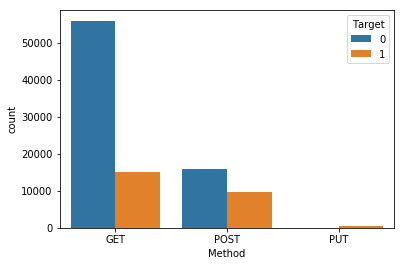

In [10]:
# counts of Method and Target
sn.countplot(x='Method', hue='Target', data=data)
plt.show()

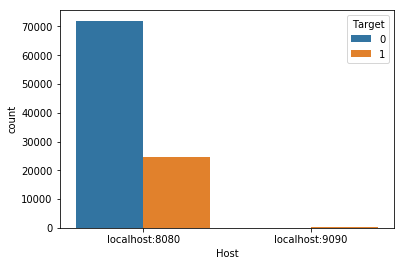

In [11]:
# counts of Host and Target
sn.countplot(x='Host', hue='Target', data=data)
plt.show()

## Classification

Firstly, ``Method`` variable as a factor variable should be hot-encoded.

In [12]:
from sklearn.preprocessing import OneHotEncoder
data_onehot = data.copy()
data_onehot = pd.get_dummies(data_onehot, columns=['Method'], prefix = ['Method'])

get = data_onehot['Method_GET'].values.reshape(len(data_onehot['Method_GET']), 1)
post = data_onehot['Method_POST'].values.reshape(len(data_onehot['Method_GET']), 1)
put = data_onehot['Method_PUT'].values.reshape(len(data_onehot['Method_GET']), 1)

# three columns corresponding to hot-encoded Method 
getpostput = np.concatenate((get, post, put), axis = 1)

Secondly, text data need to be converted into features. We will use ``TfIdfVectorizer`` which converts a collection of raw text to a matrix of TF-IDF features. TF-IDF (term frequency–inverse document frequency) reflects how important a specific word (or in our case character) is.  In our case, ``TfIdfVectorizer`` performs better than ``CountVectorizer``.

Experiments have shown that *classifiers* perform better when we concatenate text data and then vectorize rather than firstly vectorize and then concatenate. Experiments have also shown that *classifiers* perform better without ``ContentLength`` variable (our focus is to avoid large feature space).

In [13]:
y = data.Target

concatenated = data['URL'] + data['Cookie'] + data['Payload']

#we want to avoid large feature space, so we are using n_gram from 2 to 3
vectorizer = TfidfVectorizer(analyzer = 'char', ngram_range=(2,3))
text_vectorized = vectorizer.fit_transform(concatenated)

##classifiers perform better without contentlength
#contentlength = data['ContentLength'].values.reshape(len(data['ContentLength']), 1)

import scipy.sparse
feature_matrix = scipy.sparse.hstack([getpostput, text_vectorized])
print('Shape of chosen feature matrix: ', feature_matrix.shape)

Shape of chosen feature matrix:  (97065, 30666)


In [14]:
X_train, X_test, y_train, y_test = train_test_split(feature_matrix, y, test_size=0.1) 
#80% training, 20% testing data
#randomization of testing data
#furthermore, check the ratio between normal/anomalous in testing data to maintain diversity
print('Anomalous/normal ratio in test data:', sum(y_test) / y_test.shape[0])

Anomalous/normal ratio in test data: 0.2616668383640672


In case of anomaly detection we often encounter imbalanced data, which is, as we can see from the ratio, not our case.

### Logistic regression
First classifier to try is **Logistic regression** as it is easily interpretable and fast to compute. 

Test accuracy for Logistic Regression: 0.9814
F1 score for Logistic Regression: 0.9633


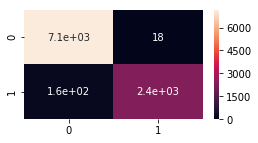

In [15]:
#Logistic Regression
lgr = LogisticRegression(solver = 'lbfgs', max_iter = 1000)
lgr.fit(X_train, y_train)
y_pred = lgr.predict(X_test)
acc_test = accuracy_score(y_test, y_pred)
f1_test = f1_score(y_test, y_pred, average='binary')
conf_matrix = confusion_matrix(y_test, y_pred)

print("Test accuracy for Logistic Regression: %.4f" % acc_test)
print("F1 score for Logistic Regression: %.4f" % f1_test)

cm = pd.DataFrame(conf_matrix, index = range(2), columns = range(2))
plt.figure(figsize=(4, 2))
sn.heatmap(cm, annot=True)
plt.show()

Initial results are promising but still not great. 

Metrics we use for classification are following: accuracy, confusion matrix and F1 score.

For clarity, **confusion matrix** consists of four numbers:
*  ``True Positive (TP)``
*  ``True Negative (TN)``,
*  ``False Positive (FP)`` which predicts 0 for true 1, thus predicts *normal* for true *anomalous*,
*  ``False Negative (FN)`` which predicts 1 for true 0, thus predicts *anomalous* for true *normal*.

When looking at confusion matrix, we prefer the ``FP`` to be smaller than ``FN`` as we rather prefer duo *predicted condition: anomalous* + *true condition: normal* when we are mistaken than the other way around. 

A combination of $\text{precision}$ and $\text{recall}$ is **$F_1$ score**, which is defined as $2  \frac{\text{precision} \times \text{recall}}{\text{precision} + \text{recall}}$, where $\text{precision} = \frac{\text{TP}}{\text{TP} + \text{FP}} $ and $\text{recall} = \frac{\text{TP}}{\text{TP}+\text{FN}}$. $F_1$ score is used for binary classification as a additional metric to accuracy.

$K$-fold cross-validation divides training data into $k$ folds. The prediction function is learned using $k-1$ folds, and the fold left out is used for validation. This is done to check model generalization and potential risk of overfitting.

In [16]:
kfold = cross_val_score(lgr, feature_matrix, y, cv=5)
print('5-fold cross-validation results:' , kfold)

5-fold cross-validation results: [0.96955648 0.96950497 0.9709473  0.97187452 0.96981404]


### Support Vector Machines

Another used classifier is **Support Vector Machine** classifier. Results are much better than for Logistic Regression.

Test accuracy for SVM: 0.9954
F1 score for SVM: 0.9911


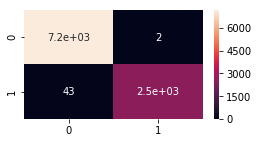

In [17]:
#Support Vector Machine (linear) classifier
svm = LinearSVC(max_iter=1000)
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
acc_test = accuracy_score(y_test, y_pred)
f1_test = f1_score(y_test, y_pred, average='binary')
conf_matrix = confusion_matrix(y_test, y_pred)

print("Test accuracy for SVM: %.4f" % acc_test)
print("F1 score for SVM: %.4f" % f1_test)

cm = pd.DataFrame(conf_matrix, index = range(2), columns = range(2))
plt.figure(figsize=(4, 2))
sn.heatmap(cm, annot=True)
plt.show()

In [18]:
kfold = cross_val_score(svm, feature_matrix, y, cv=5)
print('5-fold cross-validation results:' , kfold)

5-fold cross-validation results: [0.97821048 0.97857106 0.97954979 0.97908618 0.97867408]


As mentioned, classification results for **Support Vector Machines** are much better than those for **Logistic Regression**. All metrics suggest that the classification is well-performing and there is no overfitting. 

### Random Forest

Another classifier to focus on is **Random Forest** which are being widely used for anomaly detection. Number of Decision trees in the forest is set to 150, which was found out by experiment.

Test accuracy for Random Forest: 0.9849
F1 score for Random Forest: 0.9709


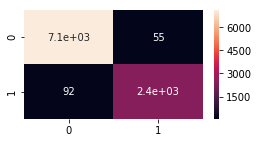

In [19]:
rfc = RandomForestClassifier(n_estimators = 150)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
acc_test = accuracy_score(y_test, y_pred)
f1_test = f1_score(y_test, y_pred, average='binary')
conf_matrix = confusion_matrix(y_test, y_pred)

print("Test accuracy for Random Forest: %.4f" % acc_test)
print("F1 score for Random Forest: %.4f" % f1_test)

cm = pd.DataFrame(conf_matrix, index = range(2), columns = range(2))
plt.figure(figsize=(4, 2))
sn.heatmap(cm, annot=True)
plt.show()

In [20]:
kfold = cross_val_score(rfc, feature_matrix, y, cv=5)
print('5-fold cross-validation results:' , kfold)

5-fold cross-validation results: [0.96543553 0.96728996 0.96559007 0.9644053  0.96507495]


As can be seen, **Random Forest** with this settings does not perform as good and as fast as proposed **SVM**.

Another classifier to use would be **Neural Network**, either deep or shallow, but with this kind of classification metrics' results, computation speed and interpretability there is little reason to do so.

## Conclusion

This Jupyter Notebook is concerned with analyzing **CSIC 2010** dataset and for interview assignment for Blindspot Solutions. 

CSIC 2010 dataset was parsed and analyzed in the first part of this notebook. 
Four variables from the parsed dataframe (``Method``, ``URL``, ``Cookie`` and ``Payload``) were used. Factor variable was hot-encoded and text was vectorized by tf-idf vectorizer.
As mentioned in the email, supervised techniques could be used so three classifiers were used, namely **Logistic Regression**, **Support Vector Machine** and **Random Forest**. All used metrics (accuracy, F1, confusion matrix) suggest that the best performing classifier for our feature space is **SVM**. Additionally, feature space is not that small so algorithm like **SVM** performs way faster than **Random Forest**.

The classification metrics of **SVM** are close to 99.5% test accuracy, 99.1% $F_1$ score and ~97.9% 5-fold cross validation accuracy. 